# KOSPI는 다른 차트의 변동성과 어떤 연관이 있을까?

## 데이터 가져오기

In [1]:
# !pip install finance-datareader

In [22]:
#프리셋처럼 그냥 통으로 때려박아놓기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN

import FinanceDataReader as fdr

In [4]:
kospi = fdr.DataReader('KS11')
kospi["Change"] = kospi["Change"] * 100
kospi.drop(["Open", "High", "Low", "Close", "Volume", "UpDown", "Comp", "Amount", "MarCap"], axis=1, inplace=True)
kospi.rename(columns={"Change" : "KOSPI change"}, inplace=True)

In [5]:
kospi.head(1)

,KOSPI change
Date,
2001-06-11,-2.18


In [6]:
sp500 = fdr.DataReader('S&P500', "2001-06-08")
sp500["Change"] = round(sp500["Adj Close"].pct_change() * 100, 2)
sp500.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1, inplace=True)
sp500.drop("2001-06-08", axis=0, inplace=True)
sp500.rename(columns={"Change" : "S&P500 change"}, inplace=True)

In [7]:
sp500.head(1)

,S&P500 change
Date,
2001-06-11,-0.84


In [8]:
japan = fdr.DataReader('N225', "2001-06-08")
japan["Change"] = round(japan["Adj Close"].pct_change() * 100, 2)
japan.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1, inplace=True)
japan.drop("2001-06-08", axis=0, inplace=True)
japan.rename(columns={"Change" : "Nikkei change"}, inplace=True)

In [9]:
japan.head(1)

,Nikkei change
Date,
2001-06-11,-1.52


In [10]:
dollar = fdr.DataReader('USD/KRW', "2001-06-08")
dollar["Change"] = round(dollar["Adj Close"].pct_change() * 100, 2)
dollar.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1, inplace=True)
dollar.rename(columns={"Change" : "USD/KRW"}, inplace=True)

In [11]:
dollar.head(1)

,USD/KRW
Date,
2003-12-01,NaN


In [12]:
us10 = fdr.DataReader('US10YT', "2001-06-08")
us10["Change"] = round(us10["Adj Close"].pct_change() * 100, 2)
us10.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1, inplace=True)
us10.drop("2001-06-08", axis=0, inplace=True)
us10.drop("2001-06-10", axis=0, inplace=True)
us10.rename(columns={"Change" : "US 10y change"}, inplace=True)

In [13]:
us10.head(1)

,US 10y change
Date,
2001-06-11,-0.86


In [14]:
nasdaq = fdr.DataReader("IXIC", "2001-06-08")
nasdaq["Change"] = round(nasdaq["Adj Close"].pct_change() * 100, 2)
nasdaq.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume"], axis=1, inplace=True)
nasdaq.drop("2001-06-08", axis=0, inplace=True)
nasdaq.rename(columns={"Change" : "NASDAQ change"}, inplace=True)

In [15]:
nasdaq

,NASDAQ change
Date,
2001-06-11,-2.00
2001-06-12,-0.04
2001-06-13,-2.23
2001-06-14,-3.66
2001-06-15,-0.77
...,...
2024-01-17,-0.59
2024-01-18,1.35
2024-01-19,1.70


## 병합

In [16]:
df = pd.concat([kospi, sp500, japan, dollar, us10, nasdaq], axis=1)
df.drop("2024-01-24",axis=0, inplace=True)

#날짜가 없는 NaN을 어떻게 할 것인가?
#평균값을 구해서 때려넣기
df.fillna(df.mean(), inplace=True)
df = round(df,2) #DataFrame인 df의 모든 값을 소수점 둘째 자리까지 반올림

In [19]:
df

,KOSPI change,S&P500 change,Nikkei change,USD/KRW,US 10y change,NASDAQ change
Date,,,,,,
2001-06-11,-2.18,-0.84,-1.52,0.01,-0.86,-2.00
2001-06-12,-0.18,0.12,-2.92,0.01,-0.89,-0.04
2001-06-13,1.14,-1.13,-0.13,0.01,0.32,-2.23
2001-06-14,-0.05,-1.75,0.18,0.01,-0.80,-3.66
2001-06-15,0.85,-0.45,-0.44,0.01,0.25,-0.77
...,...,...,...,...,...,...
2024-01-18,0.17,0.88,-0.03,0.47,0.93,1.35
2024-01-19,1.34,1.23,1.40,-0.48,0.05,1.70
2024-01-21,0.03,0.03,0.03,0.01,0.00,0.04


## K-Mean을 사용한 군집 분류

In [24]:
X = df[["S&P500 change","Nikkei change","USD/KRW","US 10y change","NASDAQ change"]]
y = df["KOSPI change"]

In [28]:
inertias = []
for k in range(1,10):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertias.append(model.inertia_)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

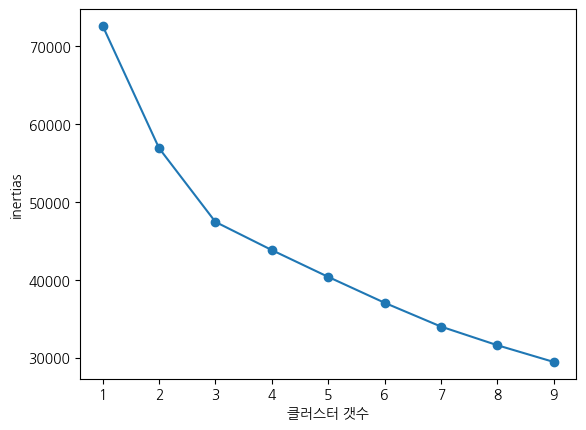

In [31]:
plt.plot(range(1,10), inertias, '-o')
plt.xlabel("클러스터 갯수")
plt.ylabel("inertias")
plt.xticks(range(1,10))
plt.show()